# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [5]:
# Check if we have a GPU available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.


In [6]:
'''def download_file(url, file_path):
    import requests
    r = requests.get(url)
    with open(file_path, 'wb') as f:
        f.write(r.content)

def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

dataset = 'downloaded_books/shakespeare.txt' # Other options are mark_twain.txt, charles_dickens.txt

download_file(f'https://raw.githubusercontent.com/UofT-DSI/deep_learning/main/assignments/downloaded_books/' + dataset, dataset)

# Load chosen dataset. NOTE: If Colab is running out of memory, change the `fraction` parameter to a value between 0 and 1 to load less data.
text = load_dataset(dataset, fraction=0.1)

text'''

"def download_file(url, file_path):\n    import requests\n    r = requests.get(url)\n    with open(file_path, 'wb') as f:\n        f.write(r.content)\n\ndef load_dataset(file_path, fraction=1.0):\n    with open(file_path, 'r', encoding='utf-8') as f:\n        raw_text = f.read()\n    return raw_text[:int(fraction * len(raw_text))]\n\ndataset = 'downloaded_books/shakespeare.txt' # Other options are mark_twain.txt, charles_dickens.txt\n\ndownload_file(f'https://raw.githubusercontent.com/UofT-DSI/deep_learning/main/assignments/downloaded_books/' + dataset, dataset)\n\n# Load chosen dataset. NOTE: If Colab is running out of memory, change the `fraction` parameter to a value between 0 and 1 to load less data.\ntext = load_dataset(dataset, fraction=0.1)\n\ntext"

In [7]:
dataset = 'downloaded_books/shakespeare.txt'

fraction = 0.1
with open(dataset, 'r', encoding='utf-8') as file:
    raw_text = file.read()
text = raw_text[:int(fraction * len(raw_text))]

print(text[:500])

The Project Gutenberg EBook of Hamlet, by William Shakespeare

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org


Title: Hamlet

Author: William Shakespeare

Editor: Charles Kean

Release Date: January 10, 2009 [EBook #27761]

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJE


# 1. Data Preparation (Complete or Incomplete)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [8]:
# Print first 1000 characters

print(text[:1000])

The Project Gutenberg EBook of Hamlet, by William Shakespeare

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org


Title: Hamlet

Author: William Shakespeare

Editor: Charles Kean

Release Date: January 10, 2009 [EBook #27761]

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK HAMLET ***




Produced by David Starner, Curtis Weyant and the Online
Distributed Proofreading Team at https://www.pgdp.net









    Transcriber's Note:
    This is a heavily edited version of _Hamlet_. It was used
    for Charles Kean's 1859 stage production. Phrases printed
    in italics in the book are indicated in this electronic
    version by _ (underscore). Footnotes originally appeared
    at the bottom of each page. For this electronic version
    the footnotes 

In [9]:
# Calculate the size of the dataset (number of characters)
dataset_size = len(text)

# Find the unique characters in the dataset by converting the text to a set
unique_characters = set(text)

# Count the number of unique characters
num_unique_characters = len(unique_characters)

# Display the results
print(f"Dataset size (number of characters): {dataset_size}")
print(f"Number of unique characters: {num_unique_characters}")


Dataset size (number of characters): 935886
Number of unique characters: 131


## 1.2 Text Pre-Processing

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [10]:
# Display number of common words in our file

import re
from collections import Counter

# Tokenize the text into words (convert text to lowercase to ensure case insensitivity
words = re.findall(r'\w+', text.lower())

# Count the frequency of each word
word_counts = Counter(words)

# Step 3: Find the total count of common words (words with frequency > 1)
common_word_counts = sum(count for word, count in word_counts.items() if count > 1)

# Display the total count of common words
print(f"Total number of common words (appear more than once): {common_word_counts}")

Total number of common words (appear more than once): 154089


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

VOCAB_SIZE = 1000
OOV_TOKEN = '<OOV>'

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts([text])

print(text[:1000])
print(f"Vocabulary size: {VOCAB_SIZE}")

The Project Gutenberg EBook of Hamlet, by William Shakespeare

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org


Title: Hamlet

Author: William Shakespeare

Editor: Charles Kean

Release Date: January 10, 2009 [EBook #27761]

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK HAMLET ***




Produced by David Starner, Curtis Weyant and the Online
Distributed Proofreading Team at https://www.pgdp.net









    Transcriber's Note:
    This is a heavily edited version of _Hamlet_. It was used
    for Charles Kean's 1859 stage production. Phrases printed
    in italics in the book are indicated in this electronic
    version by _ (underscore). Footnotes originally appeared
    at the bottom of each page. For this electronic version
    the footnotes 

If everything worked, the following line should show you the first 10 words in the vocabulary:

In [12]:
try:
    print(list(tokenizer.word_index.items())[:10])
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it."
)


[('<OOV>', 1), ('the', 2), ('and', 3), ('of', 4), ('to', 5), ('a', 6), ('in', 7), ('i', 8), ('that', 9), ('you', 10)]


## 1.3 Sequence Generation

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [13]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

SEQ_LENGTH = 20

# Convert the text to a list of token IDs
sequences = tokenizer.texts_to_sequences([text])[0]

print(f"Total number of tokens: {len(sequences)}")
print(f"Vocabulary size: {len(tokenizer.word_index) + 1}")  # Including OOV token

# Ensure there are enough tokens for training
if len(sequences) <= SEQ_LENGTH:
    raise ValueError("Text is too short to create sequences of the specified length.")

# Generate the training sequences and targets
X = []  # Sequences for the model input
y = []  # Corresponding target tokens

# Create sequences of SEQ_LENGTH and the following token as the target
for i in range(SEQ_LENGTH, len(sequences)):
    X.append(sequences[i-SEQ_LENGTH:i])  # Sequence of tokens of length SEQ_LENGTH
    y.append(sequences[i])  # Target token (the next word)

# Convert lists to numpy arrays for model training
X = np.array(X, dtype=np.int32)  # Using int32 for token IDs
y = np.array(y, dtype=np.int32)  # Using int32 for target tokens

print(f"Number of training sequences: {len(X)}")
print(f"Shape of X: {X.shape}")  # Should be (number of sequences, SEQ_LENGTH)
print(f"Shape of y: {y.shape}")  # Should be (number of sequences, 1)

# Check the first sequence and its corresponding target token
print(f"First training sequence: {X[0]}")
print(f"First target value: {y[0]}")


Total number of tokens: 156671
Vocabulary size: 13219
Number of training sequences: 156651
Shape of X: (156651, 20)
Shape of y: (156651,)
First training sequence: [  2  56  54 411   4 107  28 668 172  20 411  13  16   2 176   4 669   1
  33  43]
First target value: 1


Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [14]:
if len(X) > 0 and len(y) > 0:
    print(f'Sequence: {X[0]}\nTarget: {y[0]}')
    print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')
else:
    print("Training sequences have not been generated. Possible issue: Complete the relevant section of the assignment to initialize it.")


Sequence: [  2  56  54 411   4 107  28 668 172  20 411  13  16   2 176   4 669   1
  33  43]
Target: 1
Translated back to words: ['the', 'project', 'gutenberg', 'ebook', 'of', 'hamlet', 'by', 'william', 'shakespeare', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', '<OOV>', 'at', 'no'] -> <OOV>


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [15]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

# Ensure that tokenizer has been initialized
if tokenizer is not None:
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # One last thing: let's drop any examples where the target is the OOV token - we don't want our model to predict that (boring!)
    if OOV_TOKEN in tokenizer.word_index:
        mask = y != tokenizer.word_index[OOV_TOKEN]
        X = X[mask]
        y = y[mask]

    # One-hot encode the target token
    y = to_categorical(y, num_classes=VOCAB_SIZE)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
else:
    print("Tokenizer has not been initialized. Please initialize it and load the vocabulary before continuing.")

X_train shape: (95694, 20)
y_train shape: (95694, 1000)


# 2. Model Development (Complete or Incomplete)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [16]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Hyperparameters
vocab_size = 1000  # Size of the vocabulary (input dimension)
embedding_dim = 128  # Size of the dense representation (embedding dimension)
rnn_units = 256  # Number of units in the recurrent layer
output_dim = vocab_size  # Same as vocab size for token prediction

# Model Architecture
model = Sequential([
    # Embedding layer: Maps input tokens to dense vectors
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=None, name="Embedding_Layer"),
    
    # Recurrent layer: LSTM layer to process sequences
    LSTM(units=rnn_units, return_sequences=False, name="LSTM_Layer"),
    
    # Dense output layer with softmax activation: Produces probability distribution
    Dense(units=output_dim, activation='softmax', name="Output_Layer")
])


# Check if the model has layers before trying to print the summary
if len(model.layers) > 0:
    model.summary()
else:
    print("No layers have been added to the model. Please complete the assignment by adding the required layers.")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Embedding_Layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Layer (LSTM)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 2.2 Model Compilation

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

_your explanation here_

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, SEQ_LENGTH))  
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Embedding_Layer (Embedding)     │ (None, 20, 128)        │       128,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Layer (LSTM)               │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1000)           │       257,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 779,240 (2.97 MB)

 Trainable params: 779,240 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
output = model.predict(X_train[:1])
print(f"Model output shape: {output.shape}")
print(f"Expected y shape: {y_train[:1].shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Model output shape: (1, 1000)
Expected y shape: (1, 1000)


## 2.3 Model Training

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [19]:
from sklearn.model_selection import train_test_split

# Parameters
epochs = 5
batch_size = 128

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of training and validation data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

# Train the model
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=epochs, 
    batch_size=batch_size, 
    verbose=1
)


X_train shape: (95694, 20)
y_train shape: (95694, 1000)
X_val shape: (23924, 20)
y_val shape: (23924, 1000)
Epoch 1/5
748/748 ━━━━━━━━━━━━━━━━━━━━ 90s 115ms/step - accuracy: 0.0631 - loss: 5.7595 - val_accuracy: 0.1045 - val_loss: 5.2253
Epoch 2/5
748/748 ━━━━━━━━━━━━━━━━━━━━ 118s 84ms/step - accuracy: 0.1189 - loss: 5.0806 - val_accuracy: 0.1337 - val_loss: 4.8442
Epoch 3/5
748/748 ━━━━━━━━━━━━━━━━━━━━ 69s 93ms/step - accuracy: 0.1387 - loss: 4.7119 - val_accuracy: 0.1475 - val_loss: 4.6663
Epoch 4/5
748/748 ━━━━━━━━━━━━━━━━━━━━ 69s 92ms/step - accuracy: 0.1557 - loss: 4.5066 - val_accuracy: 0.1561 - val_loss: 4.5552
Epoch 5/5
748/748 ━━━━━━━━━━━━━━━━━━━━ 73s 97ms/step - accuracy: 0.1735 - loss: 4.3302 - val_accuracy: 0.1640 - val_loss: 4.4790


In [20]:
# Evaluate the model with accuracy and loss

loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

748/748 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.1638 - loss: 4.4846
Validation Loss: 4.479029655456543
Validation Accuracy: 0.1640193909406662


In [21]:
# Check for NaN or Inf values in the datasets
'''print(f"Check NaN in X_train: {np.isnan(X_train).any()}")  # Check for NaN in features
print(f"Check NaN in y_train: {np.isnan(y_train).any()}")  # Check for NaN in labels
print(f"Check Inf in X_train: {np.isinf(X_train).any()}")  # Check for Inf in features
print(f"Check Inf in y_train: {np.isinf(y_train).any()}")  # Check for Inf in labels'''

'print(f"Check NaN in X_train: {np.isnan(X_train).any()}")  # Check for NaN in features\nprint(f"Check NaN in y_train: {np.isnan(y_train).any()}")  # Check for NaN in labels\nprint(f"Check Inf in X_train: {np.isinf(X_train).any()}")  # Check for Inf in features\nprint(f"Check Inf in y_train: {np.isinf(y_train).any()}")  # Check for Inf in labels'

Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

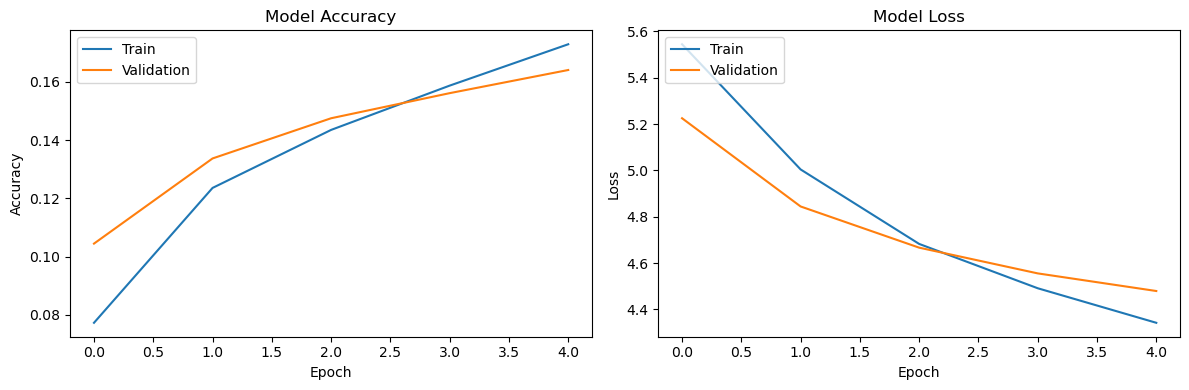

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# 3. Text Generation (Complete or Incomplete)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.

In [23]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# Predict the next token
def get_predicted_word(model, sequence):
    yhat = model.predict(sequence, verbose=0)
    return np.random.choice(range(yhat.shape[1]), p=yhat.ravel())

# Generate text
def generate_text(model, tokenizer, seed_text, max_sequence_len, num_words=50):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    generated_text = seed_text

    for _ in range(num_words):
        token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')
        predicted_token = get_predicted_word(model, token_list)
        token_list = token_list[0][1:].tolist() + [predicted_token]
        predicted_word = tokenizer.index_word.get(predicted_token, '')
        generated_text += ' ' + predicted_word if predicted_word else ''
    
    return generated_text


In [24]:
# Test the text generation function
generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)

'hamlet is a cold with little own false our most who of the reading but what in a brother and cry r c in those is here then that they didst there appears from leonato by he called paid to beatrice sir he should so the chain and as my brother'

It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small. 

# 4. Model Refinement (Complete or Incomplete)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras. 
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

In [25]:
#!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

In [26]:
#!unzip glove.6B.zip

In [27]:
# Load the pre-trained embeddings

import numpy as np
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
except FileNotFoundError:
    print("'glove.6B.100d.txt' File not found. Please make sure you have ran the previous cell.")

Found 400000 word vectors.


In [28]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    # Create an embedding matrix
    embedding_matrix = np.zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [29]:
embedding_dim = 100

# Prepare embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
# Define a new model and train it

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.optimizers import Adam

# Define the model with optimized parameters
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, 
              output_dim=embedding_dim, 
              input_length=SEQ_LENGTH, 
              weights=[embedding_matrix], 
              trainable=False),  # Use pre-trained embeddings without updating weights
    
    Bidirectional(LSTM(128, return_sequences=True)),  # Bidirectional LSTM for better context
    Dropout(0.3),  # Dropout for regularization
    LSTM(64),  # Reduced units in the second LSTM for efficiency
    Dense(128, activation='relu'),  # Slightly larger dense layer for learning complex patterns
    Dropout(0.3),  # Apply dropout to dense layer
    
    Dense(VOCAB_SIZE, activation='softmax')  # Output layer
])

# Compile the model with optimized learning rate
model.compile(optimizer=Adam(learning_rate=0.0005),  # Reduced learning rate for stable convergence
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │       100,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,000 (390.62 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 100,000 (390.62 KB)

In [35]:
# Train the model 

history = model.fit(
    X_train, y_train, 
    epochs=10,  
    batch_size=128,  
    validation_data=(X_val, y_val), 
    verbose=1  # Show training progress
)

Epoch 1/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 62s 75ms/step - accuracy: 0.0504 - loss: 5.9038 - val_accuracy: 0.0840 - val_loss: 5.2970
Epoch 2/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.0880 - loss: 5.2529 - val_accuracy: 0.1044 - val_loss: 5.0078
Epoch 3/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 56s 75ms/step - accuracy: 0.1039 - loss: 4.9972 - val_accuracy: 0.1208 - val_loss: 4.8528
Epoch 4/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 55s 73ms/step - accuracy: 0.1195 - loss: 4.8518 - val_accuracy: 0.1315 - val_loss: 4.7526
Epoch 5/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 55s 73ms/step - accuracy: 0.1270 - loss: 4.7456 - val_accuracy: 0.1379 - val_loss: 4.6853
Epoch 6/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 55s 73ms/step - accuracy: 0.1345 - loss: 4.6611 - val_accuracy: 0.1416 - val_loss: 4.6390
Epoch 7/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 55s 74ms/step - accuracy: 0.1394 - loss: 4.6039 - val_accuracy: 0.1428 - val_loss: 4.6000
Epoch 8/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.1455 - loss: 4.5380 - 

In [36]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')


748/748 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.1524 - loss: 4.5301
Validation Loss: 4.522315979003906
Validation Accuracy: 0.15210667252540588


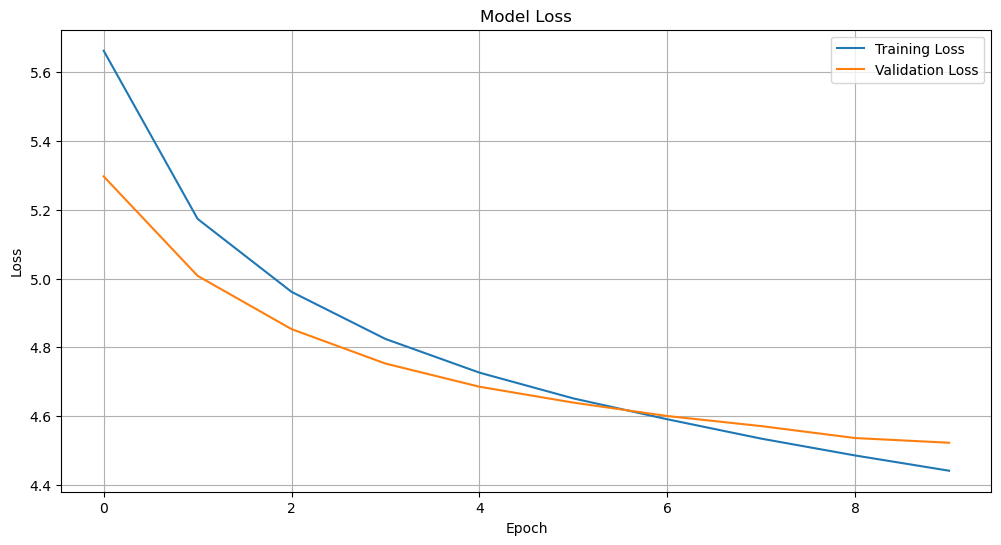

In [37]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨**Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)**🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.